# LCPB 22-23 Exercise 2 (Restricted Boltzmann Machines) 

<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |

## Introduction

Restricted Boltzmann Machines (RBM) are a type of generative model that can learn a probability distribution over the input data in an unsupervised manner. RBMs are particularly useful for binary datasets, where the input features can take only binary values. RBMs have a wide range of applications in machine learning and have been used in the development of deep learning models.  

The aim of RBMs is to learn a set of weights that allow the model to generate similar data to the input data. This is achieved by training the RBM on a set of input data and adjusting the weights to minimize the likelihood of generating the same input data. Once the RBM has been trained, it can be used to generate new data that is similar to the training data.

In this exercise we will train a RBM on a binary dataset representing polar (P) and non-polar (N) amino acids. The train will be performed with a series of techniques and remarks described in [Mehta et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0370157319300766?via%3Dihub). 
After the traning will be complete, we will use our RBM to generate a new dataset and we will use it to denoise the original dataset, with the goal of having alternating sequence of polar and non-polar amino acids (e.g `PNPNP` or `NPNPN`).

## Importing packages

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

# random seed for reproducibility
npr.seed(12345)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

from IPython.display import display_html

## Importing Dataset and defining initial variables

In [2]:
# Selecting the data we want to work with
CASE = 1
if CASE == 0:
    data_name = 'DATA'
    # size of each block of data (!= 1 for one-hot)
    BLSIZE = 1
    # number of hidden units
    M = 3
elif CASE == 1:
    dname = 'DATA_b'
    BLSIZE = 4
    M = 3
elif CASE == 2:
    dname = 'DATA_c'
    BLSIZE = 6
    M = 2

fname = dname + '/x_RBM_q0.1.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible
v = np.loadtxt(fname, delimiter=' ', dtype=int)

# Store in v0, because later we will shuffle v
v_0 = np.copy(v)

# N=size of input
N = len(v)

# L=size of each sample
L = len(v[1])

# If SPINS = True, values in {-1, +1}, otherwise {0, 1}
SPINS = False

if SPINS:
    # sigmoid takes into account energy diff = 2
    GAP = 2
    # convert 0, 1 -> -1, 1
    v = 2 * v - 1
    VMIN = -1 
else:
    GAP = 1
    VMIN = 0

# Range of each initial weight
sigma = np.sqrt(4 / float(L + M))

# Initial weights from a normal distribution
w = sigma * npr.randn(L, M)
a = sigma * np.random.randn(L)
b = np.zeros(M)

print("w[:3] =", w[:3])
print("a =", a[:3])
print('...')

w_0, a_0, b_0 = np.copy(w), np.copy(a), np.copy(b)

w[:3] = [[-0.085369    0.19973318 -0.21662092]
 [-0.23175556  0.81978717  0.5810904 ]
 [ 0.03874526  0.11749627  0.32070458]]
a = [ 0.35972076 -0.00418359  0.02085534]
...


## Reading weights with [0,1] and [-1,+1]

RBMs can be trained with both [0,1] and [-1,+1] spins, depending on the specific application and the nature of the input data.

When using [0,1] spin, the `sigmoid` activation function is typically used, which maps the input values to the range [0,1]. This makes it easier to read and interpret the weights. However, when using [-1,+1] spin, a different activation function must be chosen. This is because the range of the input values is different, and the sigmoid function is not suitable.
Some examples of activation functions that can be used with [-1,+1] spin are the hyperbolic tangent (`tanh`) and the Rectified Linear Unit (`ReLU`) function.

When we refer to "reading weights" in the context of RBMs, we are talking about the values of the weight matrix (`w` in the code) that connects the visible and hidden units. These weights represent the strength of the connections between the units and are adjusted during the training process to learn the probability distribution over the input data. By reading the values of the weights, we can gain insights into how the RBM is representing the input data and potentially use this information for applications such as feature learning or anomaly detection.

## Original Dataset visualization

In [3]:
def is_one(cell_value):
    color0 = 'background-color: blue; color: white'
    color1 = 'background-color: cyan;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v_0[:N1])

df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

df=df0
t=[i for i in range(N1)]
g = pd.Categorical(df[t]).codes # convert groups to indices  
df.style.apply(
    lambda x: ['background-color: {}'.format("#FFCCCC") for i in g], 
    # comment the 2nd line if working w/ case 0 or 1. Otherwise comment the 1st one
    subset=[0,1,2,3, 8,9,10,11, 16,17,18,19 ]
    #subset=[0,1,2,3,4,5, 12,13,14,15,16,17, 23,24,25,26,27,28,29]
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


## Defining "tree" plot function

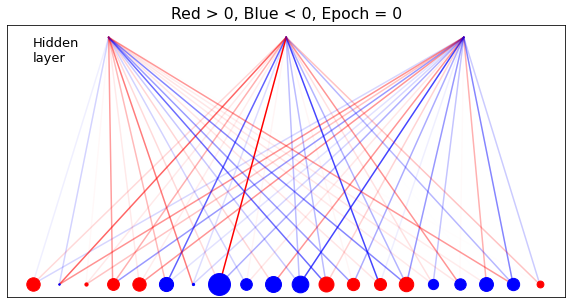

In [4]:
(x_v, y_v) = (np.zeros(L), np.linspace(-0.5, 0.5, L))
(x_h, y_h) = (np.ones(M), np.linspace(-0.35, 0.35, M))

def mycolor(value):
    if value > 0: return 'red'
    elif value < 0: return 'blue'
    return 'black'

# plot network with weights and units, all color-coded
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # remove ticks
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

    # scale for line width based on max weight
    lw_scale = 1 / abs(w).max()
    for i in range(L):
        for j in range(M):
            ex = (y_v[i], y_h[j])
            ey = (x_v[i], x_h[j])
            col = mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=lw_scale*abs(w[i][j]))

    # scale for circles representing the units
    c_scale = 500
    
    # plot visible units
    for i in range(L):
        ax.scatter(y_v[i], x_v[i], s=c_scale * abs(a[i]),
                   zorder=2, c=mycolor(a[i]))

    # plot hidden units (with square markers)
    for j in range(M):
        ax.scatter(y_h[j], x_h[j], s=min(300, c_scale * abs(b[j])),
                   zorder=2, c=mycolor(b[j]), marker='s')
    
    ax.set_title(f'Red > 0, Blue < 0, Epoch = {epoch}')
    ax.text(-0.5, 0.9, 'Hidden\nlayer')
    plt.show()
    
'''
def plotgraph_vert(epoch=0):
    # scale for line width based on max weight
    lw_scale = 2 / abs(w).max()
    for i in range(L):
        for j in range(M):
            ex = (x_v[i], x_h[j])
            ey = (y_v[i], y_h[j])
            col = mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=lw_scale * abs(w[i][j]))

    # scale for circles based on max couplings
    c_scale = 300 / (a.max() + b.max())

    # plot visible units
    for i in range(L):
        plt.scatter(x_v[i], y_v[i], s=c_scale*abs(a[i]),
                    zorder=2, c=mycolor(a[i]))
        
    # plot hidden units (with square markers)
    for j in range(M):
        plt.scatter(x_h[j], y_h[j], s=c_scale*abs(b[j]),
                    zorder=2, c=mycolor(b[j]), marker='s')

    plt.figaspect(1)
    plt.title(f'Red > 0, Blue < 0, Epoch = {epoch}')
    plt.show()
'''
# Plotting relations between visible units and hidden variables;
# Lines are the weights;
# The size of the feaures (circles, squares, lines) is a proxy 
# for the abs value of the visible bias, hidden bias, weights;

plotgraph()

## Defining Activation Function w/ cdf

In [5]:
def activate(in_layer, weights, bias, phase, info=False):
    act = bias + np.dot(in_layer, weights)

    # prepare a list of -1s or 0s (depending on SPINS = T/F)
    out_layer = np.full(act.shape, VMIN, dtype=int)

    if phase == 1: # positive phase of CD
        
        r = npr.random_sample((len(act), ))
        
        # like below but simpler (no cdf, only two levels)
        prob = 1 / (1 + np.exp(-GAP * act))
        out_layer[r < prob] = 1
    else:
        # n° of samples
        n_sample = len(act) // BLSIZE
        p = npr.random_sample((n_sample, ))
        for i in range(n_sample):
            
            # cumulated boltzmann weights
            block = act[(i * BLSIZE):((i + 1) * BLSIZE)]
            prob = np.cumsum(np.exp(GAP * block))
            
            # normalization (so the tail of cdf is 1)
            prob /= prob[-1]
            
            # put out_layer = 1 in the previous index to the one where
            # the generated number is higher than the cdf 
            out_layer[np.argmax(p[i] < prob) + i * BLSIZE] = 1

    if info: # print debug
        print(f'in_layer = {in_layer}') 
        print(f'act = {act}')
        print(f'prob = {prob}')
        print(f'out_layer = {out_layer}')

    return out_layer

## Defining Optimizers (ADAM and RMSProp)

In [6]:
def rmsprop(data, model, s, beta1, eps, lrate):
    g = data - model # gradient
    s1 = beta1 * s + (1 - beta1) * g**2
    d = lrate * g / (np.sqrt(s1) + eps)

    return s1, d

def adam(data, model, m, s, t, beta1, beta2, eps, lrate):
    g = data - model # gradient
    m0 = beta1 * m + (1 - beta1) * g
    s0 = beta2 * s + (1 - beta2) * g**2
    
    m1 = m0 / (1 - beta1**(t + 1))
    s1 = s0 / (1 - beta2**(t + 1))

    #lr_t = lrate * np.sqrt(1 - beta2**t) / (1 - beta1**t)
    d = lrate * m1 / (np.sqrt(s1) + eps)

    return m0, s0, d#, lr_t

## Defining Energy and Probability partition functions

In [7]:
def energy_part(h, w, a):
        energy_bin = []
        E_n = [] 
        for i in range(4):
            energy_vec = np.zeros((1, 4))
            energy_vec[:, i] = 1
            energy_bin.append(energy_vec) 
        for i in range (4):
            energy_p = np.dot((np.dot(h, w) + a).T, energy_bin[i])
            E_n.append(energy_p)
        return E_n, energy_bin
        
    
    # Temperature: if the temp is too low, the energy of the 1st level can be too low, and the prob
    # would be the dom factor and the "extraction" from the cumulative can be misleading 
def prob_part(E_n, ampl = 0.05):
    p_n = []
    Z = np.sum(E_n)
    for i in range(4):
        pe_i = np.exp(-np.sum(E_n[i])*ampl) / Z
        p_n.append(pe_i)
    return p_n
    
    
    
def Energy(v, h, w, a, b):
    return -a.dot(v)-h.dot(b)-((v.T).dot(w)).dot(h)

def PartZ(w, a, b):
    res = 0
    '''if SPINS==True:
        for i in range(2**M):
            h=np.array(reversed([(i//2**j)%2 for j in range(M)]))
            for j in range(L//BLSIZE):
                
              
    '''    
    if SPINS==False:
        for i in range(2**M):
            h=np.array([(i//2**j)%2 for j in reversed(range(M))])
            res = np.exp(b.dot(h))
            expact = np.exp(a+w.dot(h))
            for j in range(L//BLSIZE):
                res*=sum(expact[j*BLSIZE:(j+1)*BLSIZE])
    return res

## Training the model


Here we train the model. We specify the initial learning rate `lrate`, the minibatch size `m_size`, the number of epochs `n_epochs` and some model parameters.  
The code allows to choose between different optimizers: `ADAM`, `RMSProb` (defined above) and `Vanilla GD` (defined below in the code).  
In the code below one can choose how many Contrastive Divergence steps, `CD_steps`, the model must do.

During one epoch the model runs the Constrastive Divergence method. In the negative phase (`phase==0`) the code recall the One-Hot Encoding algorithm.  

At the end of each minibatch the values of the weigths, visible biases and hidden biases (`w`, `a`, `b`) are updated, from values driven by the optimizer.

For every visible unit the code calculates the correspondant Boltzmann Energy. At the end of the epoch the loglikelihood is computed. If not using ADAM, after every epoch the learning rate is decreased. This can help the model to converge more slowly and avoid getting stuck in local optima.

The input data are shuffled in order to remove any potential biases or patterns in the order of the data. If the input data is not shuffled, the RBM may learn to rely on the order of the data to make predictions, rather than learning the underlying distribution of the data. By shuffling the data, we ensure that the RBM is forced to learn the distribution of the data, rather than memorizing patterns in the order of the data. This can lead to better generalization performance and more accurate predictions on new data.

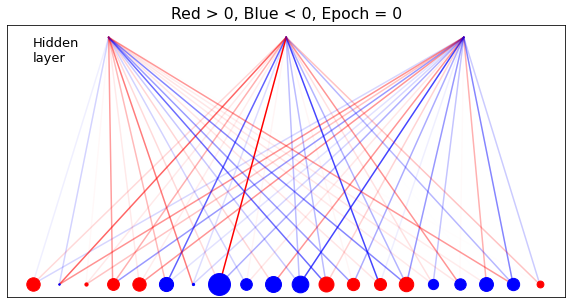

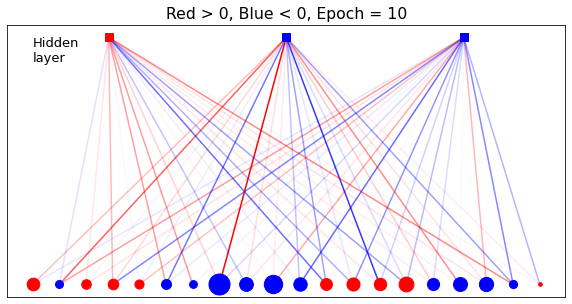

l_rate = 0.0009999000099990003


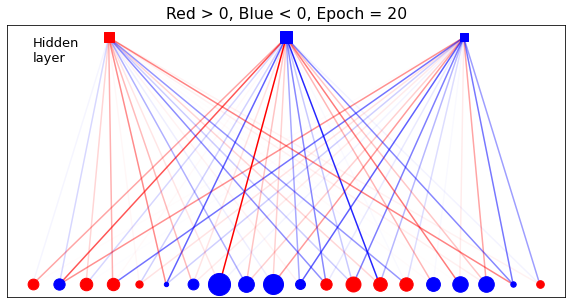

l_rate = 0.000999800039992002


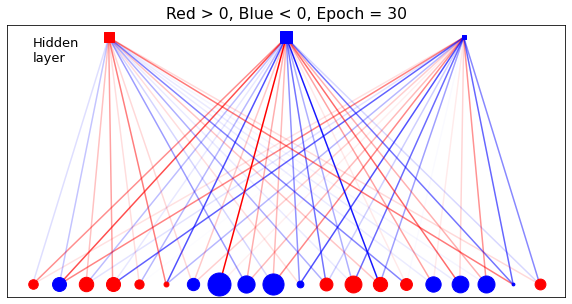

l_rate = 0.0009997000899730085


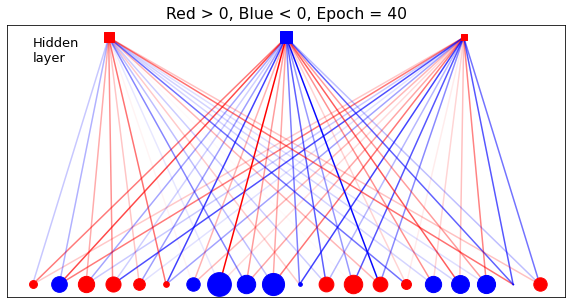

l_rate = 0.000999600159936026


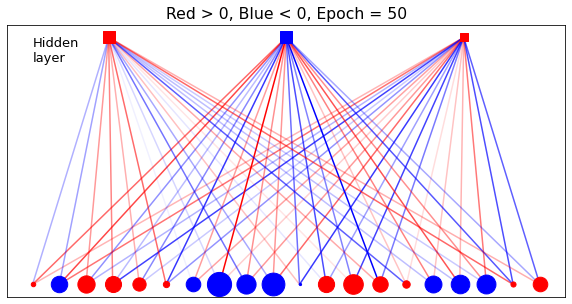

l_rate = 0.0009995002498750633


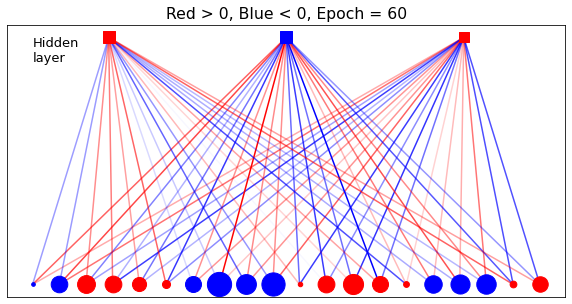

l_rate = 0.0009994003597841301


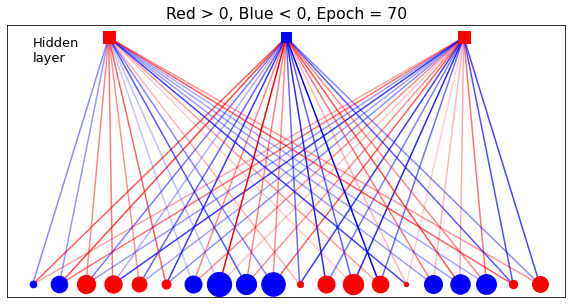

l_rate = 0.0009993004896572404


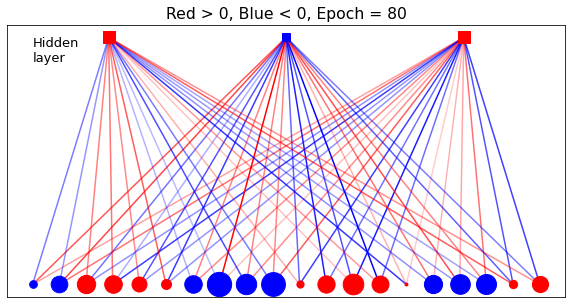

l_rate = 0.0009992006394884097


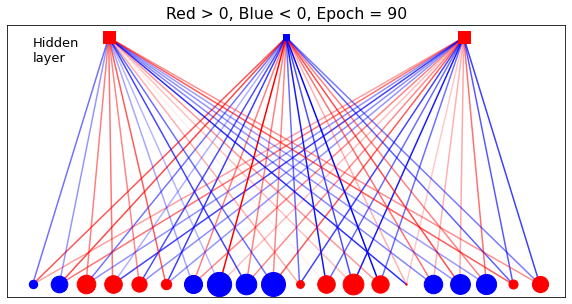

l_rate = 0.000999100809271656


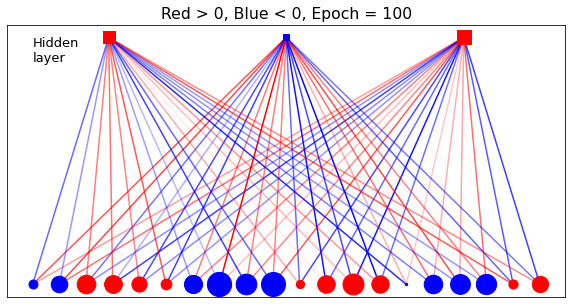

l_rate = 0.000999000999000999


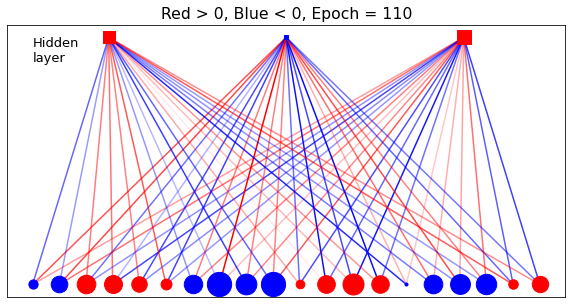

l_rate = 0.0009989012086704626


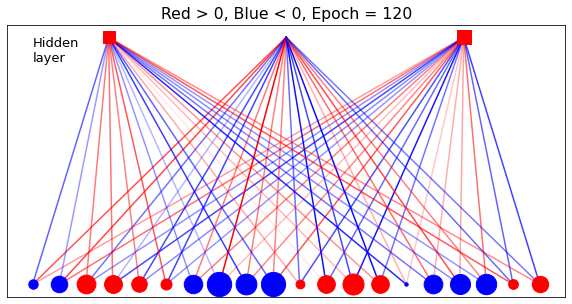

l_rate = 0.000998801438274071


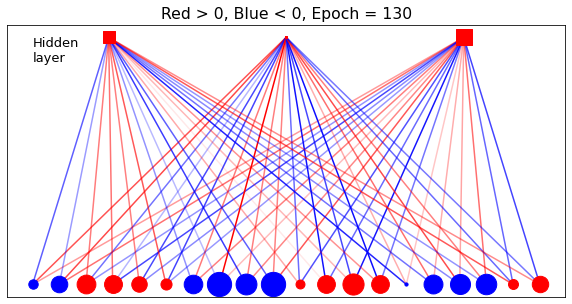

l_rate = 0.0009987016878058518


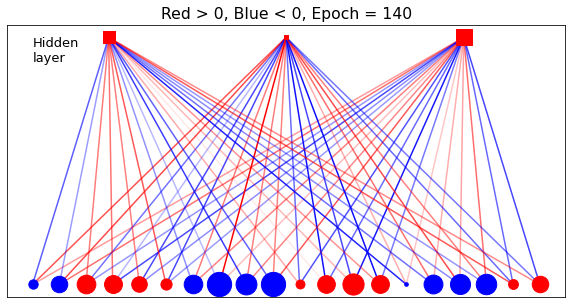

l_rate = 0.0009986019572598359


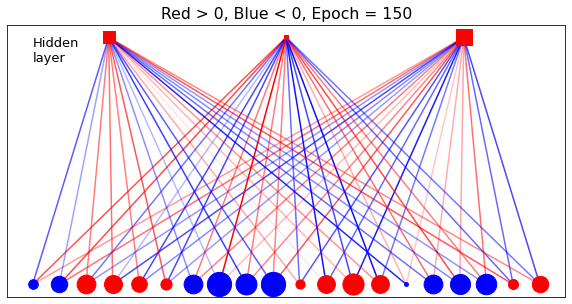

l_rate = 0.0009985022466300546


In [8]:
# Learning rate
lrate = 0.001

# Minibatch size and count
m_size, m_count = 500, 0

# model parameters
beta1 = 0.9
beta2 = 0.999 #for ADAM
eps = 1e-8

# Initializing values at 0
sw, mw = 0, 0
sa, ma = 0, 0
sb, mb = 0, 0

# Choose between 'rmsprop', 'adam', 'vanilla'
model = 'rmsprop'

# Number of CD steps
CD_steps = 1

# Number of epochs
n_epochs = 150

LogL = []
mean_energy = []
recon_error = []
r_2 = []
plotgraph(0)

# Train model
for epoch in range(n_epochs):
    
    # aggregate normalization of batch statistics and learning rate
    lrate_m = lrate /1

    # Loop over visible units
    for k in range(N):
        E = 0   
        if m_count == 0:
            # initialization step in the minibatch
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

        # Positive CD phase: generate h
        h = activate(v[k], w, b, phase=1)
        
        # Negative CD phase: generate fantasy vf w/ one-hot encoding
        vf = activate(h, w.T, a, phase=0)

        # Additional divergent steps
        for i in range(CD_steps - 1):
            hf = activate(vf, w, b, phase=1)
            vf = activate(hf, w.T, a, phase=0)

        # Positive CD phase: fantasy hf from fantasy vf
        hf = activate(vf, w, b, phase=1)

        # Update quantities
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)

        m_count += 1
        if m_count == m_size: # reached the end of minibatch
            
            # Vanilla GD
            if model == 'vanilla':
                dw = lrate_m * (vh_data - vh_model)
                da = lrate_m * (v_data - v_model)
                db = lrate_m * (h_data - h_model)
            
            # RMSprop
            elif model == 'rmsprop':
                sw, dw = rmsprop(vh_data, vh_model, sw,
                                 beta1, eps, lrate_m)
                sa, da = rmsprop(v_data, v_model, sa,
                                 beta1, eps, lrate_m)
                sb, db = rmsprop(h_data, h_model, sb,
                                 beta1, eps, lrate_m)
            # ADAM
            elif model == 'adam':
                mw, sw, dw = adam(vh_data, vh_model, mw, sw, epoch,
                                  beta1, beta2, eps, lrate_m)
                ma, sa, da = adam(v_data, v_model, ma, sa, epoch,
                                  beta1, beta2, eps, lrate_m)
                mb, sb, db = adam(h_data, h_model, mb, sb, epoch,
                                  beta1, beta2, eps, lrate_m)
                                
            w = w + dw
            a = a + da
            b = b + db
            #l_rate = lr_t
            m_count = 0 # move to the next minibatch
        E += Energy(v_data, h_data, w, a, b)
        
        #E += energy_part(h_data, w, a)
        
    # Shuffle input data
    npr.shuffle(v)
    
    # Decrease the learning rate if not using ADAM
    if (model != 'adam'):
        lrate = lrate / (1 + 0.01 * lrate)
    

    if epoch % 10 == 9:
        
        plotgraph(epoch+1)
        #if (model != 'adam'):
        #    print(f'l_rate = {lrate}')
        print(f'l_rate = {lrate}')    
    mean_energy.append(E/N)
    LogL.append(-E/N-np.log(PartZ(w, a, b)))
    recon_error.append(np.mean((v_data - v_model)**2))
    r_2.append(1-((np.sum((v_data-v_model)**2))/np.sum((v_data-np.mean(v_data))**2)))
    #LogL.append(-E/N-np.log(prob_part(E_n=E, ampl = 0.05)))
    # save files with data


In [9]:
print(LogL)

[-7.926778273963004, -10.23586689270575, -8.744055927882808, -9.22749146774252, -7.938213304498635, -7.266889158149456, -7.9070274025042195, -7.5458373364711, -8.813220600499754, -9.150167844667518, -9.475657218682585, -7.7391285045870974, -7.383318904141364, -6.149237939584246, -5.304728237788207, -6.152339435912591, -12.17767512385267, -6.894485714865122, -8.308959355006628, -7.826911650692606, -11.031125815010387, -10.582584991492123, -8.735087413916192, -11.964211307048709, -6.805042078632084, -11.876339206378553, -11.851259917926841, -14.357620470718885, -10.7114877513342, -12.40257513757145, -12.448747808279691, -10.236903391831577, -9.15726554246854, -8.618340504828682, -11.41159984469918, -13.851286556653939, -10.546985985635365, -12.996360144605042, -14.527993389970304, -17.82469016012314, -14.725746865491017, -13.48859990949733, -18.079590508459013, -17.068271025529697, -18.34647386803202, -18.162798668977945, -17.444441758341547, -18.92711922671538, -15.733757584912595, -16.

In [10]:
str_file = 'log_'+ dname + '_model-' + model + '_mini-' + str(m_size) + '_nep-' + str(n_epochs)
run_info = 'mini: ' + str(m_size) + ', opt: ' + model + ', epochs:  '+ str(n_epochs) + ', beta: ' + str(beta1) + ', CD-n: ' + str(CD_steps)
#np.savetxt(str_file + '.loglike', str(run_info))
np.savetxt(str_file + '.txt', LogL, header=str(run_info) +'\n' , delimiter=' ')

## Evolution of the loglikelihood

The loglikelihood is a measure of how well the RBM model fits the input data. It is defined as the logarithm of the likelihood function, which is the probability of the input data given the model parameters.

The loglikelihood is often negative, as the likelihood function is typically less than one. This means that we want to minimize the negative loglikelihood during training. This is typically done using gradient-based optimization methods, such as stochastic gradient descent or RMSProp, to adjust the weights of the RBM model. 
As the loglikelihood decrease, the model becomes better at capturing the underlying distribution of the input data, and is more likely to generate high-quality samples.

It is also common to use the loglikelihood per data point as a metric, as this is more easily comparable across datasets of different sizes. The loglikelihood can also be used to compare different models or hyperparameters, as models with lower loglikelihoods are generally considered to be better at capturing the underlying distribution of the data.

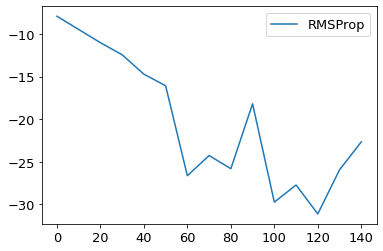

In [11]:
#mod_adam = np.genfromtxt('log_DATA_b_model-adam_mini-500_nep-100.txt')
mod_rmsprop = np.genfromtxt('log_DATA_b_model-rmsprop_mini-500_nep-150.txt')
#mod_vanilla = np.genfromtxt('log_DATA_b_model-vanilla_mini-500_nep-100.txt')

time_step = np.arange(0, n_epochs,step=10)
#plt.plot(time_step, mod_adam[0::10], label="ADAM")
plt.plot(time_step, mod_rmsprop[0::10], label="RMSProp")
#plt.plot(time_step, mod_vanilla[0::10], label="Vanilla")

plt.legend(loc="best")

# we can make a nicer plot

## Accuracy and Loss function

To compute the loss function and accuracy for a RBM, we need to define the objective function and the evaluation metric. The objective function is typically the negative log-likelihood of the training data (see before), while the evaluation metric is often the reconstruction error or the classification accuracy on a held-out test set.

The evaluation metric for a RBM can vary depending on the specific problem and dataset. In our case, we are using the RBM for feature learning, we might use the reconstruction error as the evaluation metric. 
A reconstruction error of zero is typically not achievable or desirable, as it would indicate that the RBM model is overfitting to the training data and may not generalize well to new data.

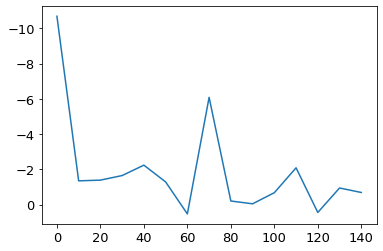

In [12]:
#plt.plot(time_step, recon_error[0::10])
plt.plot(time_step, r_2[0::10])
plt.gca().invert_yaxis()


In [13]:
acc_file = 'acc' + '_model-' + model + '_ep-' + str(n_epochs) + '_3'
acc_info = ', opt: ' + model + 'mini: ' + str(m_size) + ', epochs:  '+ str(n_epochs) + ', beta: ' + str(beta1) + ', CD-n: ' + str(CD_steps)
np.savetxt(acc_file + '.txt', recon_error, header=str(acc_info) +'\n' , delimiter=' ')

log_file = 'logL' + '_model-' + model + '_ep-' + str(n_epochs) + '_3'
log_info = ', opt: ' + model + 'mini: ' + str(m_size) + ', epochs:  '+ str(n_epochs) + ', beta: ' + str(beta1) + ', CD-n: ' + str(CD_steps)
np.savetxt(log_file + '.txt', LogL, header=str(log_info) +'\n' , delimiter=' ')

r2_file = 'r2' + '_model-' + model + '_ep-' + str(n_epochs) + '_3'
r2_info = ', opt: ' + model + 'mini: ' + str(m_size) + ', epochs:  '+ str(n_epochs) + ', beta: ' + str(beta1) + ', CD-n: ' + str(CD_steps)
np.savetxt(r2_file + '.txt', r_2, header=str(r2_info) +'\n' , delimiter=' ')

## Noise reduction

In [14]:
# large GAP <-> low temperature
GAP *= 40

# original, non-reshuffled data is in v0
v1 = np.zeros_like(v_0)
for k in range(N):
    # positive CD phase: generate h
    h = activate(v_0[k], w, b, phase=1)
    # negative CD phase: generating fantasy vf
    v1[k] = activate(h, w.T, a, phase=0)

# difference between model and data
diff = (v1 - v_0) / 2
# save files with data
str0 = fname + '_M' + str(M) + '-mini' + str(m_size)
np.savetxt(str0 + '.fantasy', (v1 + 1) / 2, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.diff', diff, fmt='%d', delimiter=' ')

# cut full dataset to first nrows rows
nrows = 20
data = np.copy(v_0[:nrows])
pred = np.copy(((v1[:nrows] - VMIN) / (1 - VMIN)).astype(int))

# convert one-hot encoding to polar/non-polar flags
one_per_block = range(0, v_0.shape[1], BLSIZE)
for i in one_per_block:
    data[:, i] = np.argmax(data[:, i:(i + BLSIZE)], axis=1)
    pred[:, i] = np.argmax(pred[:, i:(i + BLSIZE)], axis=1)
data = pd.DataFrame(data[:, one_per_block])
pred = pd.DataFrame(pred[:, one_per_block])
thresh = BLSIZE // 2
data[data < thresh] = 0
data[data >= thresh] = 'P'
pred[pred < thresh] = 0
pred[pred >= thresh] = 'P'
data[data == 0] = 'N'
pred[pred == 0] = 'N'


# stylistic manipulations
data = data.style.set_table_attributes("style='display:inline'")
pred = pred.style.set_table_attributes("style='display:inline'")

def is_polar(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold; color: black'
    if cell_value == 'P':
        return color1
    return color0
data.applymap(is_polar)
pred.applymap(is_polar)

sty = [dict(selector='caption', props=[('font-size', '150%')])]
data.set_caption('Data').set_table_styles(sty)
pred.set_caption('Model').set_table_styles(sty)

display_html(data._repr_html_() + pred._repr_html_(), raw=True)

,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,P,N,P,N,P
3,N,P,N,P,N
4,P,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,N
7,P,N,P,N,P
8,N,P,N,N,N
9,P,N,P,N,P


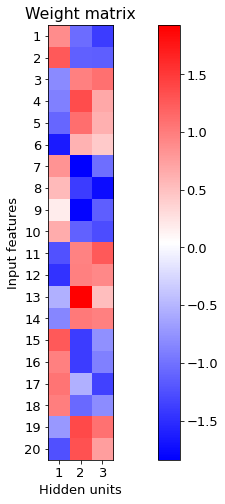

In [15]:
# create a random matrix of size (10,5)
A = BLSIZE # number of input features
G = M # number of hidden units
we = w[::-1] # weight matrix

#print(we.shape)

# plot the weight matrix using imshow()
plt.figure(figsize = (16,8))
plt.imshow(we, cmap='bwr', interpolation='nearest') # use 'bwr' colormap for blue-red contrast
plt.colorbar() # add a colorbar to show the values

plt.xticks(range(0,G), range(1,G+1))
plt.yticks(range(0,L), range(1,L+1))
plt.xlabel('Hidden units') # label the x-axis
plt.ylabel('Input features') # label the y-axis

plt.title('Weight matrix') # add a title

plt.show() # show the plot